In [12]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess

In [4]:
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/alex_character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

In [5]:
merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

In [6]:
data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(int)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

### Introduction is [here](https://docs.google.com/document/d/1LeIT4MZN_XvUmSXgLV6pjCBFyJx-ScGt0RwY6dt2cPU/edit?tab=t.rtld0lx1xfg2)

### Let's describe our dataset

The first thing we need to know is the distribution among the archetypes. Which are the most common and which are the rarest.

Desing 1

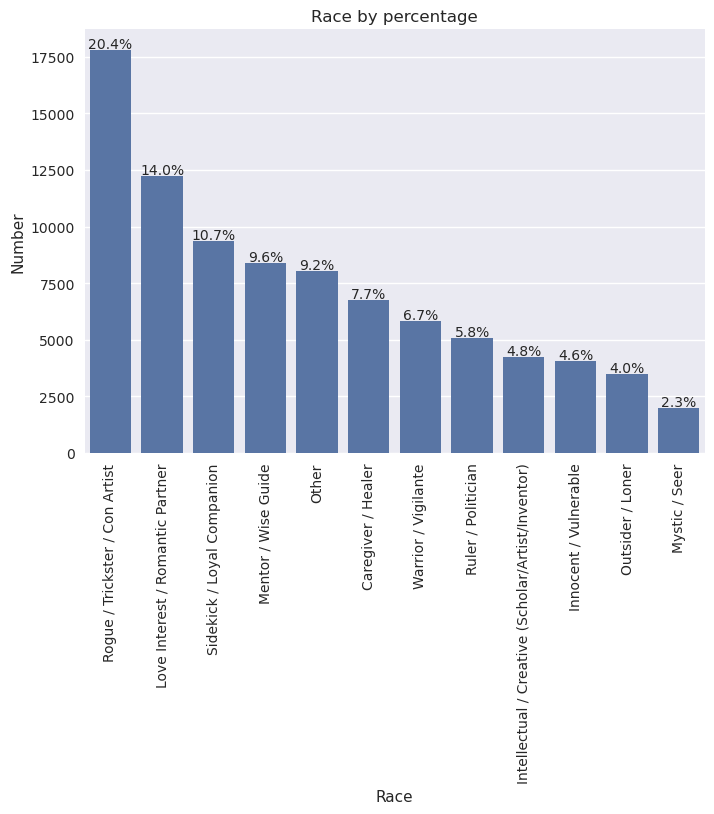

In [13]:
# Taken from https://www.kaggle.com/code/werooring/nfl-big-data-bowl-basic-eda-for-beginner
def write_percent(ax, total_size):
    '''Traverse the figure object and display the ratio at the top of the bar graph.'''
    for patch in ax.patches:
        height = patch.get_height() # Figure height (number of data)
        width = patch.get_width() # Figure width
        left_coord = patch.get_x() # The x-axis position on the left edge of the figure
        percent = height/total_size*100 # percent
        
        # Type text in the (x, y) coordinates
        ax.text(x=left_coord + width/2.0, # x-axis position
                y=height + total_size*0.001, # y-axis position
                s=f'{percent:1.1f}%', # Text
                ha='center') # in the middle


with plt.style.context('seaborn-v0_8'):
    plt.title("Race by percentage")
    ax = sns.countplot(x=data.archetype, order=data.archetype.value_counts().sort_values(ascending=False).index)
    write_percent(ax, len(data.archetype.dropna()))
    plt.xlabel("Race")
    plt.xticks(rotation=90)
    plt.ylabel("Number")

Desing 2

In [14]:
with plt.style.context('seaborn-v0_8'):
    plt.pie(data.archetype.value_counts(), labels=data.archetype.value_counts().index, autopct='%1.1f%%')

Desing 3

In [ ]:
px.pie(data, names="archetype")

The result is not unexpected. The most films are captured about extraordinary people. And statistics showed this!

- Pie for every archetype, actor_gender (actor), race(actor), ethn_name(actor), nationality(actor), education(actor), religion(actor), place_of_birth(actor)
- Histograms for actor_height (actor), years_in_film, weight (actor), 
- How many different archetypes in films

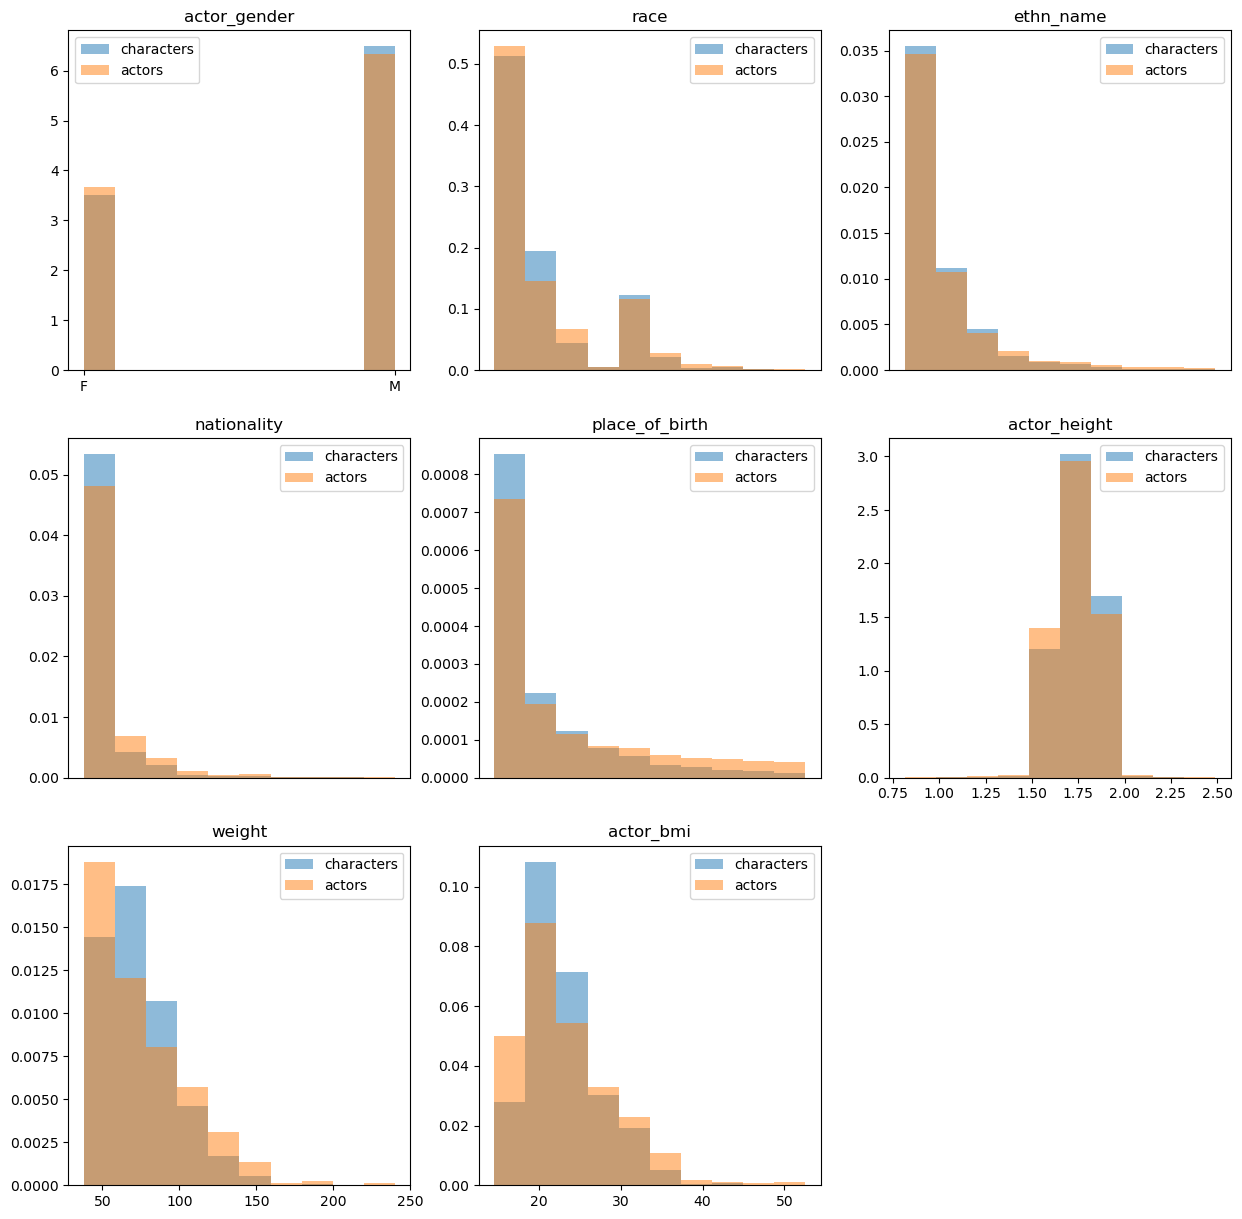

In [13]:
data_uniq_actor = data.drop_duplicates(subset=["fb_actor_id"])

plt.figure(figsize=(3*5, 3*5))
# plt.subplot(3, 3)

for i, s in enumerate(["actor_gender", "race", "ethn_name", "nationality", "place_of_birth", "actor_height", "weight", "actor_bmi"]):
    plt.subplot(3, 3, i + 1)
    plt.title(s)
    plt.hist(data[s].dropna(), density=True, alpha=0.5, label="characters")
    plt.hist(data_uniq_actor[s].dropna(), density=True, alpha=0.5, label="actors")
    plt.legend()
    if s in ["race", "place_of_birth", "ethn_name", "nationality"]:
        plt.xticks([])

# should do on unique!

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=2, 
    specs=[
        [{"type": "pie"}, {"type": "pie"}],
        [{"type": "pie"}, {"type": "pie"}]
    ])

fig.add_trace(
    go.Pie(
        labels=merged_data.archetype.value_counts().index, 
        values=merged_data.archetype.value_counts(),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(
        labels=merged_data.actor_gender.value_counts().index, 
        values=merged_data.actor_gender.value_counts(),
    ),
    row=1, col=2
)

fig.add_trace(
    go.Pie(
        labels=merged_data.race.value_counts().index, 
        values=merged_data.race.value_counts(),
    ),
    row=2, col=1
)

fig.add_trace(
    go.Pie(
        labels=merged_data.ethn_name.value_counts().index, 
        values=merged_data.ethn_name.value_counts(),
    ),
    row=2, col=2
)

fig.show()


In [ ]:
go.Pie(labels=merged_data.archetype.value_counts().index, values=merged_data.archetype.value_counts())

Pie({
    'labels': array(['Rogue / Trickster / Con Artist', 'Love Interest / Romantic Partner',
                     'Sidekick / Loyal Companion', 'Mentor / Wise Guide', 'Other',
                     'Caregiver / Healer', 'Warrior / Vigilante', 'Ruler / Politician',
                     'Intellectual / Creative (Scholar/Artist/Inventor)',
                     'Innocent / Vulnerable', 'Outsider / Loner', 'Mystic / Seer'],
                    dtype=object),
    'values': array([17821, 12234,  9355,  8378,  8053,  6759,  5809,  5091,  4222,  4037,
                      3487,  1971])
})